# Introduction
The purpose of this competition is to try to predict, given a tweet, whether that tweet is announcing a disaster or not. In order to do this, we use will use an ensemble of the DistilBERT model and the XLNet model.

One of the goals was to see if it would be better to take the average prediction of the DistilBERT and XLNet model when predicting the true intent of these tweets, versus just applying the DistilBERT model to this task. I also wanted to see how much better this ensemble approach would be than a standard linear regression model would do. It also provided a nice opportunity to learn more about Transformers and the differences between the DistilBERT and XLNET models!

# Importing dependencies

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
import re
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification, XLNetTokenizer, TFXLNetForSequenceClassification

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Loading the data

In [2]:
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [3]:
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


Let's try to get a bit of an understanding for some of the more common keywords:

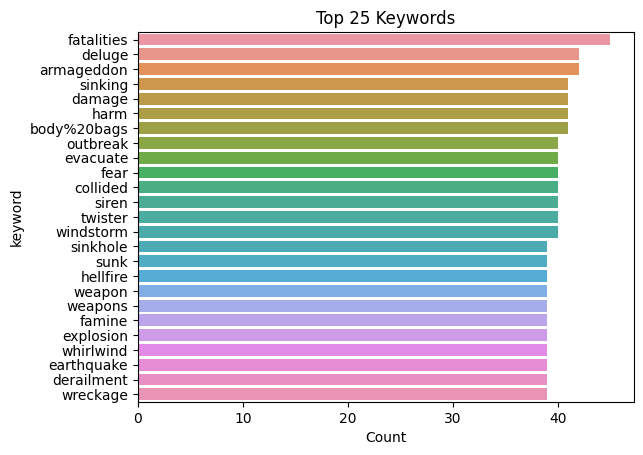

In [4]:
keywords_vc = pd.DataFrame({"Count": train_df["keyword"].value_counts()})
sns.barplot(y=keywords_vc[0:25].index, x=keywords_vc[0:25]["Count"], orient='h')
plt.title("Top 25 Keywords")
plt.show()

Perhaps we can glean something from the keywords of the disaster tweets vs the non-disaster tweets:

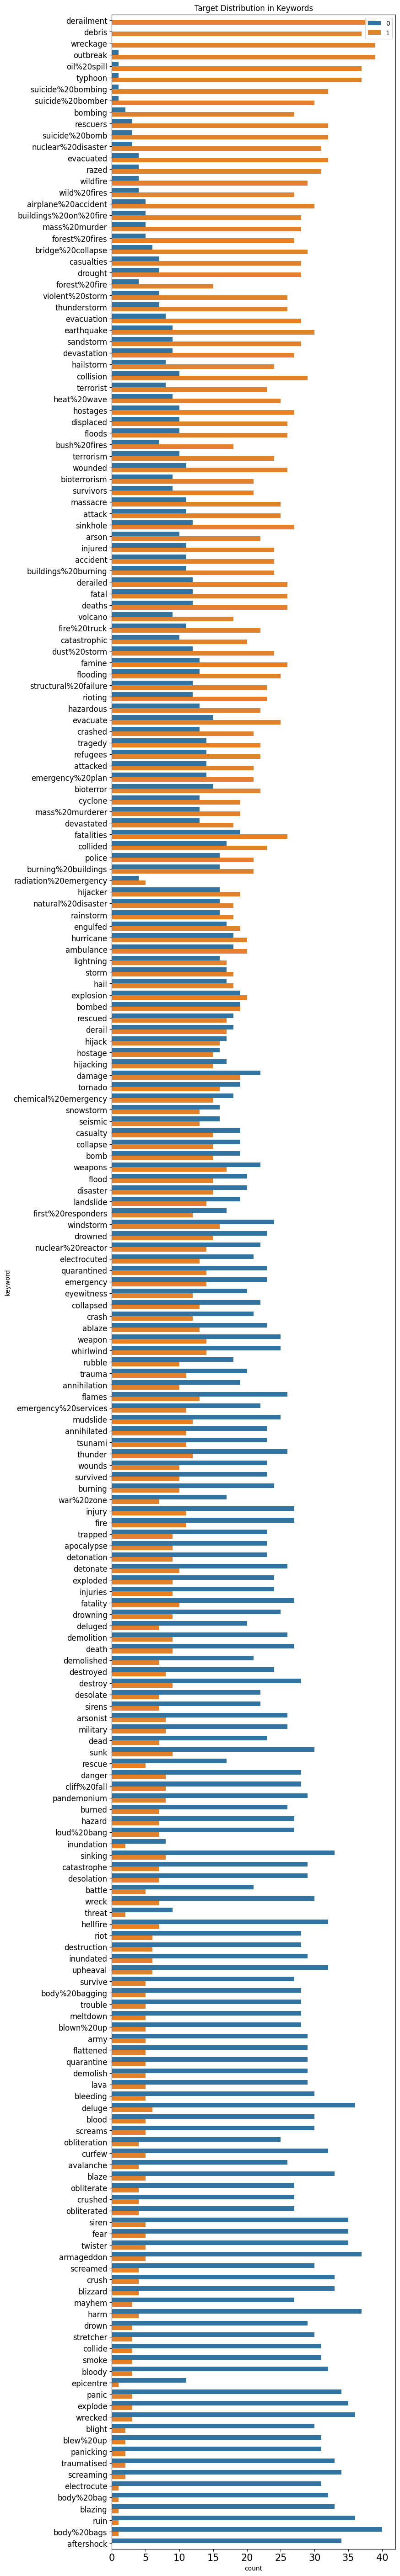

In [5]:
train_df['target_mean'] = train_df.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 72), dpi=100)

sns.countplot(y=train_df.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=train_df.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

train_df.drop(columns=['target_mean'], inplace=True)

So we can see that there are some common English words like "panic" or "wrecked" that could plausibly be talking about a disaster, but are common enough in normal conversation that they also appear frequently in negative examples. 

We can also try to use the size of the tweet as an indication of whether the tweet is talking about a natural disaster or not:

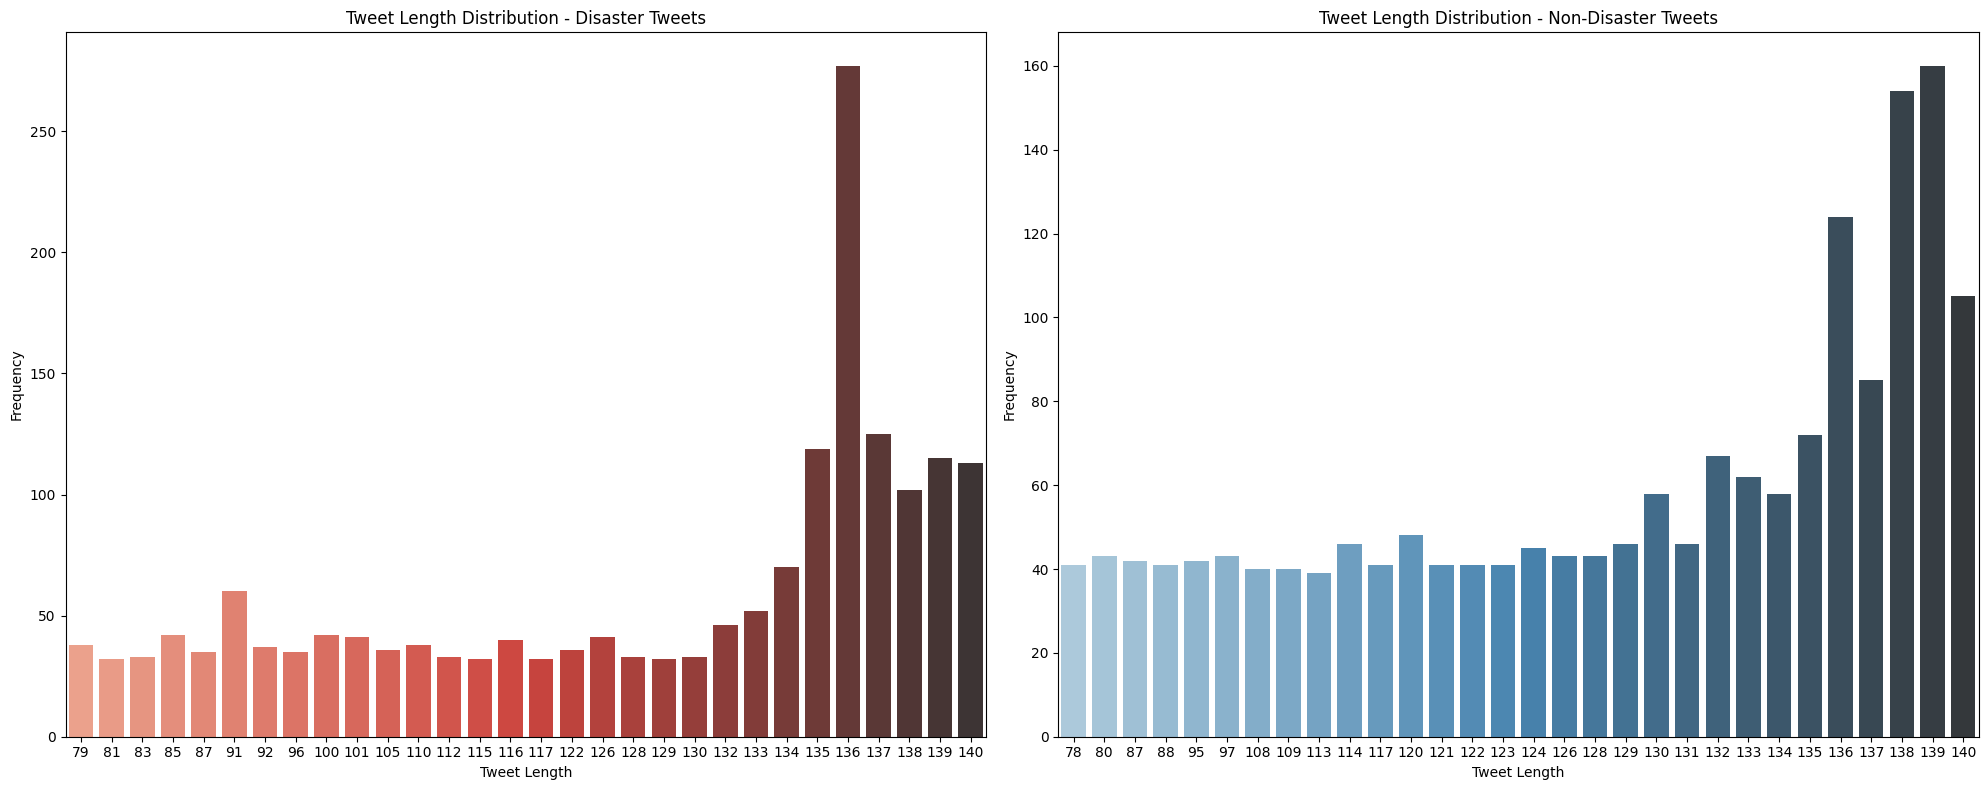

In [6]:
train_df['tweet_length'] = train_df['text'].apply(len)
    
# Filter tweets by disaster and non-disaster
disaster_lengths = train_df[train_df["target"] == 1]['tweet_length'].value_counts().head(30)
nondisaster_lengths = train_df[train_df["target"] == 0]['tweet_length'].value_counts().head(30)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

sns.barplot(x=disaster_lengths.index, y=disaster_lengths.values, ax=ax1, palette="Reds_d")
sns.barplot(x=nondisaster_lengths.index, y=nondisaster_lengths.values, ax=ax2, palette="Blues_d")

# Setting titles and labels
ax1.set(title="Tweet Length Distribution - Disaster Tweets", ylabel="Frequency", xlabel="Tweet Length")
ax2.set(title="Tweet Length Distribution - Non-Disaster Tweets", ylabel="Frequency", xlabel="Tweet Length")

plt.tight_layout()
plt.show()

# Cleaning the data

We will now clean the data by writing out all abbreviations and also removing punctuation marks.

In [7]:
#The following cleaning functions were written by: https://www.kaggle.com/code/ghaiyur/ensemble-models-versiong

In [8]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [9]:
# Remove all URLs, replace by URL
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'URL',text)

# Remove HTML beacon
def remove_HTML(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

# Remove non printable characters
def remove_not_ASCII(text):
    text = ''.join([word for word in text if word in string.printable])
    return text

# Change an abbreviation by its true meaning
def word_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

# Replace all abbreviations
def replace_abbrev(text):
    string = ""
    for word in text.split():
        string += word_abbrev(word) + " "        
    return string

# Remove @ and mention, replace by USER
def remove_mention(text):
    at=re.compile(r'@\S+')
    return at.sub(r'USER',text)

# Remove numbers, replace it by NUMBER
def remove_number(text):
    num = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
    return num.sub(r'NUMBER', text)

# Remove all emojis, replace by EMOJI
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'EMOJI', text)

# Replace some others smileys with SADFACE
def transcription_sad(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[(\\/]')
    return smiley.sub(r'SADFACE', text)

# Replace some smileys with SMILE
def transcription_smile(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[)dDp]')
    #smiley = re.compile(r'#{eyes}#{nose}[)d]+|[)d]+#{nose}#{eyes}/i')
    return smiley.sub(r'SMILE', text)

# Replace <3 with HEART
def transcription_heart(text):
    heart = re.compile(r'<3')
    return heart.sub(r'HEART', text)

# Factorize elongated words, add ELONG
def remove_elongated_words(text):
    rep = re.compile(r'\b(\S*?)([a-z])\2{2,}\b')
    return rep.sub(r'\1\2 ELONG', text)

# Factorize repeated punctuation, add REPEAT
def remove_repeat_punct(text):
    rep = re.compile(r'([!?.]){2,}')
    return rep.sub(r'\1 REPEAT', text)


# Remove all punctuations
def remove_all_punct(text):
    table = str.maketrans('','',string.punctuation)
    return text.translate(table)

# Remove punctuations
def remove_punct(text):
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" 
    for p in punctuations:
        text = text.replace(p, f' {p} ')

    text = text.replace('...', ' ... ')
    if '...' not in text:
        text = text.replace('..', ' ... ')   
    return text

# Remove all english stopwords
def remove_stopwords(text):
    text = ' '.join([word for word in text.split() if word not in (stopwords)])
    return text

In [10]:
def clean_tweet(text):
    
    # Remove non text
    text = remove_URL(text)
    text = remove_HTML(text)
    text = remove_not_ASCII(text)
    
    # Lower text, replace abbreviations
    text = text.lower()
    text = replace_abbrev(text)  
    text = remove_mention(text)
    text = remove_number(text)
    
    # Remove emojis / smileys
    text = remove_emoji(text)
    text = transcription_sad(text)
    text = transcription_smile(text)
    text = transcription_heart(text)
    
    # Remove repeated puntuations / words
    text = remove_elongated_words(text)
    text = remove_repeat_punct(text)

    #text = remove_all_punct(text)
    #text = remove_punct(text)
    #text = remove_stopwords(text)

    return text

In [11]:
# Clean text and add a new feature
train_df["clean_text"] = train_df["text"].apply(clean_tweet)
test_df["clean_text"] = test_df["text"].apply(clean_tweet)

# Importing the tokenizers for DistilBERT and XLNet

In [12]:
tokenizer_B = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
max_length = 140

def encode_text(df, tokenizer, max_length):
    return tokenizer.batch_encode_plus(
        df['clean_text'].tolist(),
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='tf'
    )

train_data_B = encode_text(train_df, tokenizer_B, max_length)
test_data_B = encode_text(test_df, tokenizer_B, max_length)

In [13]:
tokenizer_X = XLNetTokenizer.from_pretrained('xlnet-base-cased')
train_data_X = encode_text(train_df, tokenizer_X, max_length)
test_data_X = encode_text(test_df, tokenizer_X, max_length)

In [14]:
model_B = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
model_X = TFXLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=2)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

/opt/conda/lib/python3.10/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetForSequenceClassification: ['lm_loss']
- This IS expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSeq

In [15]:
batch_size_B = 10
epochs_B = 5
batch_size_X = 32
epochs_X = 3

# Training the models

In [16]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': train_data_B['input_ids'], 'attention_mask': train_data_B['attention_mask']},
    train_df['target'].values
)).shuffle(len(train_df)).batch(batch_size_B)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
model_B.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

history_B = model_B.fit(train_dataset, epochs=epochs_B)

Epoch 1/5
762/762 [==============================] - 117s 118ms/step - loss: 0.4316 - accuracy: 0.8145
Epoch 2/5
762/762 [==============================] - 77s 101ms/step - loss: 0.3171 - accuracy: 0.8761
Epoch 3/5
762/762 [==============================] - 77s 101ms/step - loss: 0.2267 - accuracy: 0.9154
Epoch 4/5
762/762 [==============================] - 76s 100ms/step - loss: 0.1411 - accuracy: 0.9506
Epoch 5/5
762/762 [==============================] - 76s 99ms/step - loss: 0.1002 - accuracy: 0.9622


We can also plot the accuracy changes through the training of the first model.

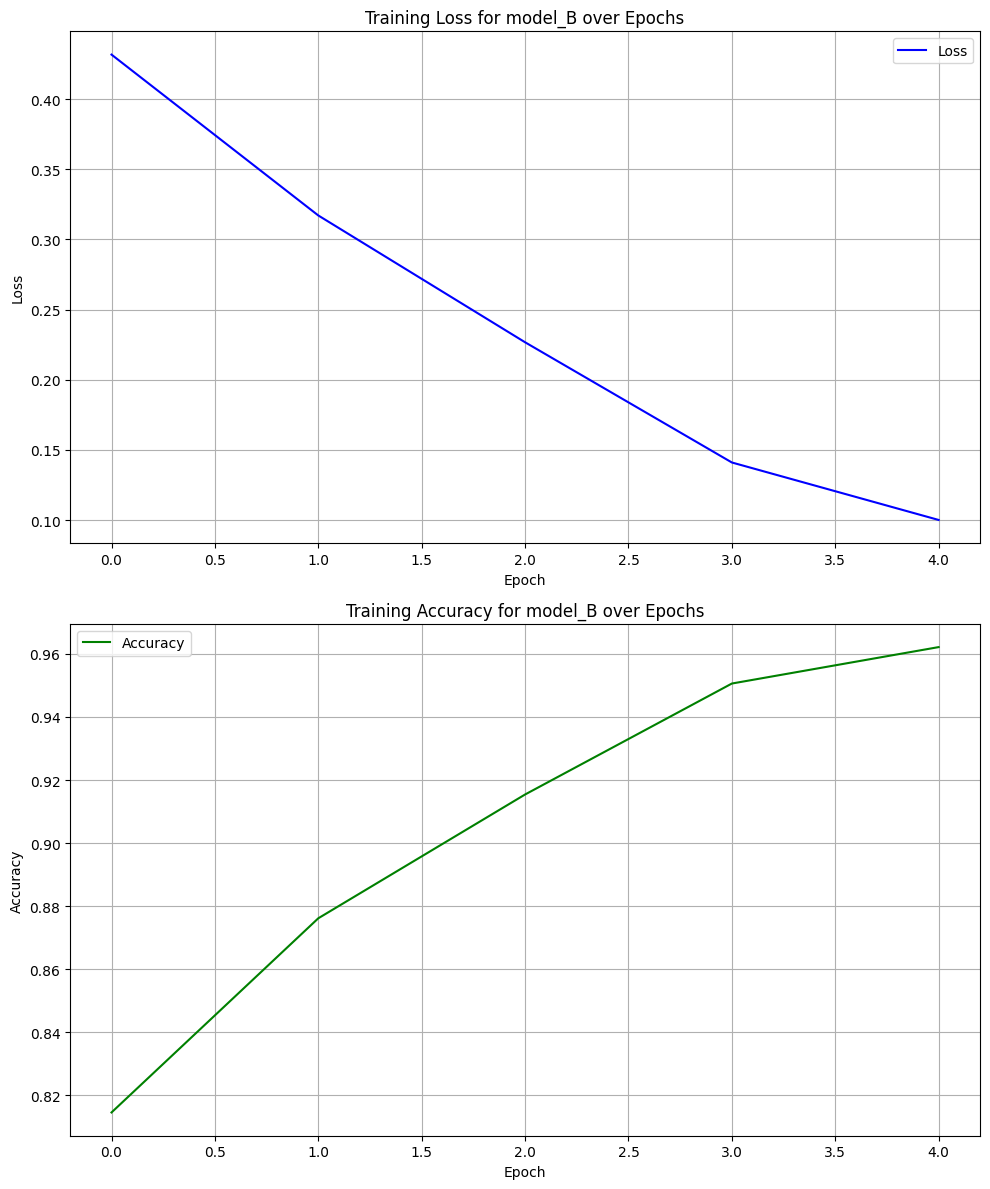

In [17]:
loss_values_B = history_B.history['loss']
accuracy_values_B = history_B.history['accuracy']

# Set up the figure and axes
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))

# Plotting the loss values
ax1.plot(loss_values_B, color='blue', label='Loss')
ax1.set_title('Training Loss for model_B over Epochs')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.legend()

# Plotting the accuracy values
ax2.plot(accuracy_values_B, color='green', label='Accuracy')
ax2.set_title('Training Accuracy for model_B over Epochs')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

In [18]:
train_dataset_X = tf.data.Dataset.from_tensor_slices((
    {'input_ids': train_data_X['input_ids'], 'attention_mask': train_data_X['attention_mask']},
    train_df['target'].values
)).shuffle(len(train_df)).batch(batch_size_X)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
model_X.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

history_X = model_X.fit(train_dataset_X, epochs=epochs_X)

Epoch 1/3
238/238 [==============================] - 207s 678ms/step - loss: 0.5010 - accuracy: 0.7541
Epoch 2/3
238/238 [==============================] - 161s 678ms/step - loss: 0.3840 - accuracy: 0.8422
Epoch 3/3
238/238 [==============================] - 161s 678ms/step - loss: 0.3249 - accuracy: 0.8697


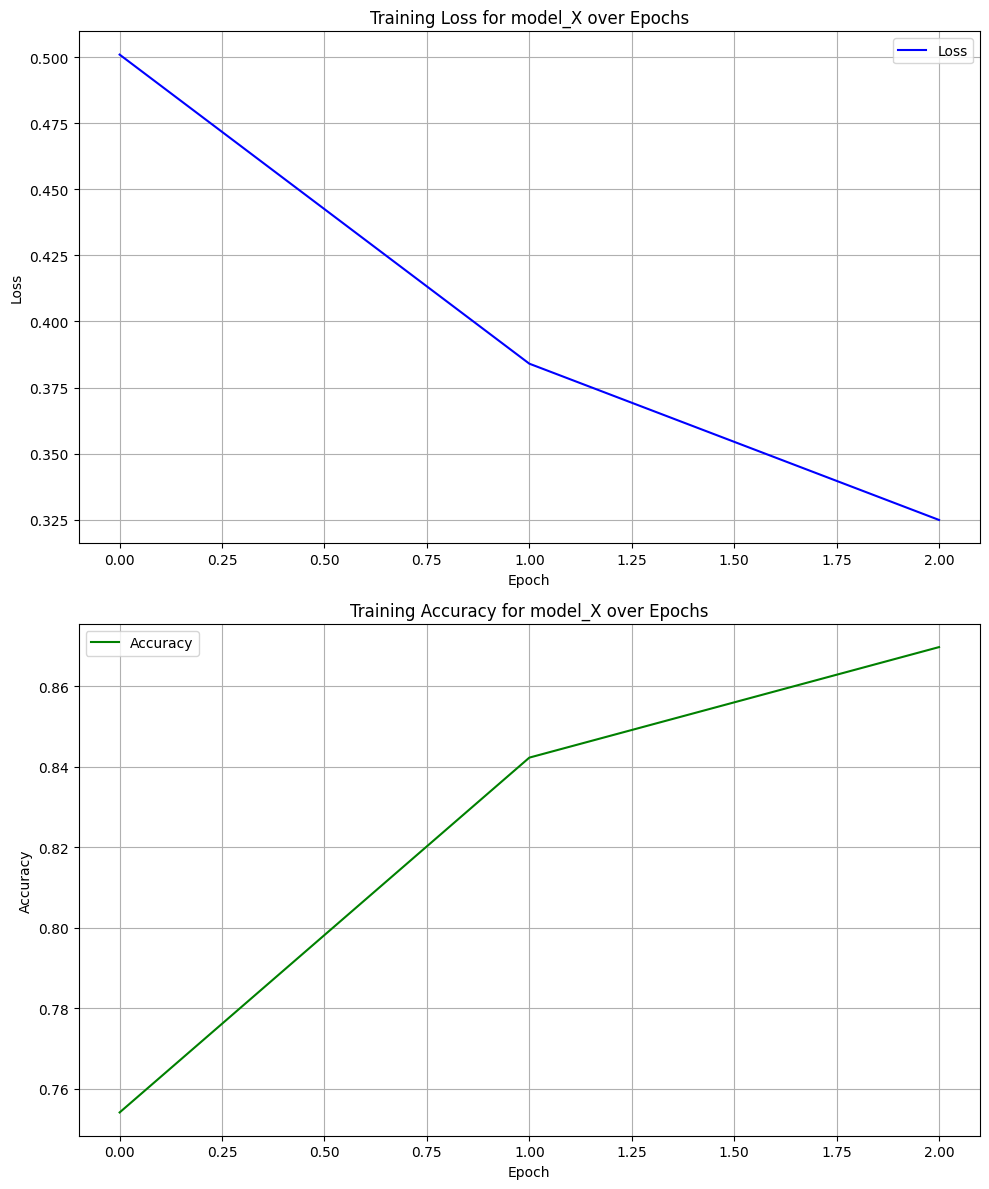

In [19]:
loss_values_X = history_X.history['loss']
accuracy_values_X = history_X.history['accuracy']

# Set up the figure and axes
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))

# Plotting the loss values
ax1.plot(loss_values_X, color='blue', label='Loss')
ax1.set_title('Training Loss for model_X over Epochs')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.legend()

# Plotting the accuracy values
ax2.plot(accuracy_values_X, color='green', label='Accuracy')
ax2.set_title('Training Accuracy for model_X over Epochs')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()


In [20]:
test_dataset_B = tf.data.Dataset.from_tensor_slices((
    {'input_ids': test_data_B['input_ids'], 'attention_mask': test_data_B['attention_mask']}
)).batch(batch_size_B)

logits1 = model_B.predict(test_dataset_B).logits

# Convert logits to class predictions
predictions1 = tf.argmax(logits1, axis=1).numpy()

327/327 [==============================] - 13s 36ms/step


In [ ]:
test_dataset_X = tf.data.Dataset.from_tensor_slices((
    {'input_ids': test_data_X['input_ids'], 'attention_mask': test_data_X['attention_mask']}
)).batch(batch_size_X)

# Get the prediction logits for both models
with tf.device('/cpu:0'):
    logits2 = model_X.predict(test_dataset_X).logits

predictions2 = tf.argmax(logits2, axis=1).numpy()

102/102 [==============================] - 692s 7s/step


# Making the final predictions and then generating the submission file

In [ ]:
final_predictions = (predictions1 + predictions2) > 1  # This will work since 0 (not disaster) + 0 = 0, 1 (disaster) + 1 = 2
final_predictions = final_predictions.astype(int)

submission = pd.DataFrame({'id': test_df['id'], 'target': final_predictions})
submission.to_csv('submission.csv', index=False)

A few things I would like to try in the future:
* Try using a larger model: both of the models selected here were moreso selected due to their relative smallness, and I wanted to play around a bit with transformer models on an interesting task
* I would also like to try and train each of the models for longer in order to have better accuracy on the training data. In different modifications of the batch size with the models, I was never able to get the accuracy to be above around 96% or so on the training data. I think this would be fixed by training longer, as each epoch the accuracy improved quite a bit.
* This ensemble structure performed much better than the baseline linear regression model that I previously implemented, but I am also curious to try making an architecture from scratch to see how well it could do, instead of the nearly 100 million parameters in these pre-trained models
* Lastly, I think it could be interesting to try to work on this problem in more languages than English, and then try to apply data augmentation after acquiring other tweets in other languages. For example, all of the tweets in the data set here are in English, but there are pre-trained models trained on large corpuses of non-English text, too and it could be interesting if the model does better on some languages than others!